<a href="https://colab.research.google.com/github/BrunoEMendes/Google_colab_NN/blob/master/GruPredictTemp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GRU PREDICT TEMPERATURE

Data extracted from "https://climateknowledgeportal.worldbank.org/download-data"

Dataset structure : [year month Rainfall Temperature]


In [203]:
import datetime
import tensorflow as tf
import numpy as np
import pandas as pd

In [204]:
from pandas import read_csv

file_url = "https://raw.githubusercontent.com/BrunoEMendes/Google_colab_NN/master/weather_predict/input/temp-rain.csv"
dataset = read_csv(file_url)
print(dataset[:12])

     Year  Month   Rainfall  Temperature
0    1901      1   95.41630      7.87119
1    1901      2   94.85550      6.38664
2    1901      3  167.21800      9.50226
3    1901      4   56.53060     13.22100
4    1901      5   41.43890     15.69000
5    1901      6   11.08040     19.98460
6    1901      7    5.27905     21.56480
7    1901      8    4.28003     22.13090
8    1901      9   99.67530     18.29120
9    1901     10   79.87950     13.71970
10   1901     11   71.79130      9.62800
11   1901     12  100.22600      6.79127


Get temp and rainfall cols only


In [205]:
df = dataset.dropna()
df = df[['Temperature', 'Rainfall']]
print(df[:12])

    Temperature   Rainfall
0       7.87119   95.41630
1       6.38664   94.85550
2       9.50226  167.21800
3      13.22100   56.53060
4      15.69000   41.43890
5      19.98460   11.08040
6      21.56480    5.27905
7      22.13090    4.28003
8      18.29120   99.67530
9      13.71970   79.87950
10      9.62800   71.79130
11      6.79127  100.22600


In [206]:
 print(df.describe())

       Temperature     Rainfall
count  1392.000000  1392.000000
mean     14.725823    68.009047
std       5.036300    58.965178
min       5.460670     0.254600
25%      10.217500    22.757625
50%      14.118400    52.278700
75%      19.695425    96.766000
max      24.551800   331.242000


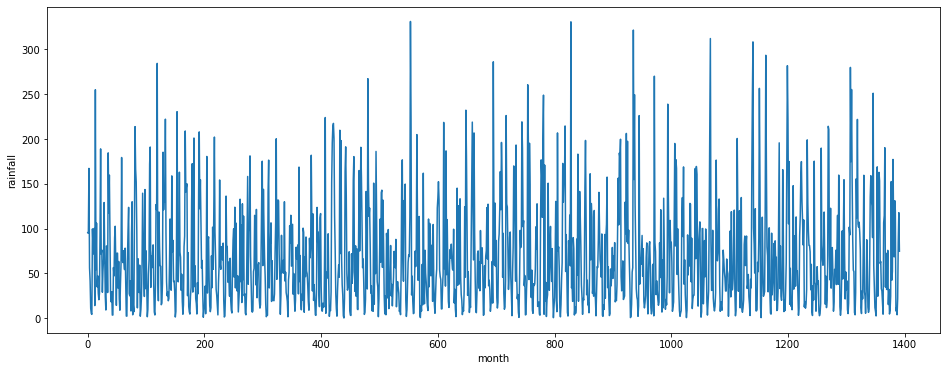

In [207]:
import matplotlib.pyplot as plt
plt.figure(1, figsize =(16, 6))
plt.plot(df.Rainfall)
plt.xlabel('month')
plt.ylabel('rainfall')
plt.show()

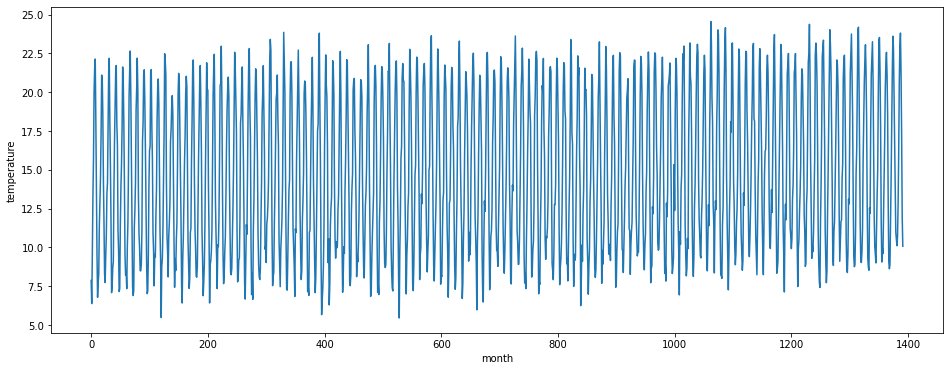

In [208]:
plt.figure(1, figsize =(16, 6))
plt.plot(df.Temperature)
plt.xlabel('month')
plt.ylabel('temperature')
plt.show()

Normalize the data between -1, 1

In [209]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler(feature_range = (-1, 1))
X = min_max_scaler.fit_transform(df.values)
print(X[:12])
print('---')
print('X data shape: ', X.shape)

[[-0.74747226 -0.42498294]
 [-0.90299474 -0.42837159]
 [-0.57660023  0.0088807 ]
 [-0.18702245 -0.6599508 ]
 [ 0.07163169 -0.75114279]
 [ 0.52153697 -0.93458482]
 [ 0.68707981 -0.96963963]
 [ 0.74638484 -0.97567623]
 [ 0.34413521 -0.39924783]
 [-0.1347783  -0.51886446]
 [-0.56342762 -0.56773762]
 [-0.86060542 -0.39592021]]
---
X data shape:  (1392, 2)


We are trying to forecast the temperatures for years to come, therefore our target(y) will correspond to the temperatures

In [210]:
y = X[:, 0]
print(y)
print('---')
print(y.shape)

[-0.74747226 -0.90299474 -0.57660023 ...  0.24248591 -0.31417051
 -0.51648436]
---
(1392,)


Split data
Test data = 20%

In [211]:
from sklearn.model_selection import train_test_split
test_size_var = 0.20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size_var, random_state = 42)
print('X train shape: ', X_train.shape)
print('Y train shape: ', y_train.shape)
print('X test shape: ', X_test.shape)
print('Y test shape: ', y_test.shape)

X train shape:  (1113, 2)
Y train shape:  (1113,)
X test shape:  (279, 2)
Y test shape:  (279,)


To predict $t + 1$ into the future we will check $n_{time\_steps}$ in the past

In [212]:
time_steps = 10

def get_data_time_steps(X, y, time_steps = 3):

    Xres = []
    yres = []

    for i in range(time_steps, len(X)):
        Xres.append(X[i - time_steps: i, : X.shape[1]])
        yres.append(y[i])

    return np.array(Xres), np.array(yres)

X_train, y_train = get_data_time_steps(X_train, y_train, time_steps)
X_test, y_test = get_data_time_steps(X_test, y_test, time_steps)

print('X train shape: ', X_train.shape)
print('Y train shape: ', y_train.shape)
print('X test shape: ', X_test.shape)
print('Y test shape: ', y_test.shape)


X train shape:  (1103, 10, 2)
Y train shape:  (1103,)
X test shape:  (269, 10, 2)
Y test shape:  (269,)


Because we now have the data, we can build our GRU model

In [217]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.recurrent import GRU

model = Sequential()
model.add(GRU(128, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

print(model.summary())

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_20 (GRU)                 (None, 128)               50688     
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 129       
Total params: 50,817
Trainable params: 50,817
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model.fit(X_train, y_train, batch_size=8, epochs=200)

Ploting last 100 predictions


9/9 [==============================] - 0s 3ms/step - loss: 0.3703
0.37028223276138306
9/9 [==============================] - 0s 3ms/step


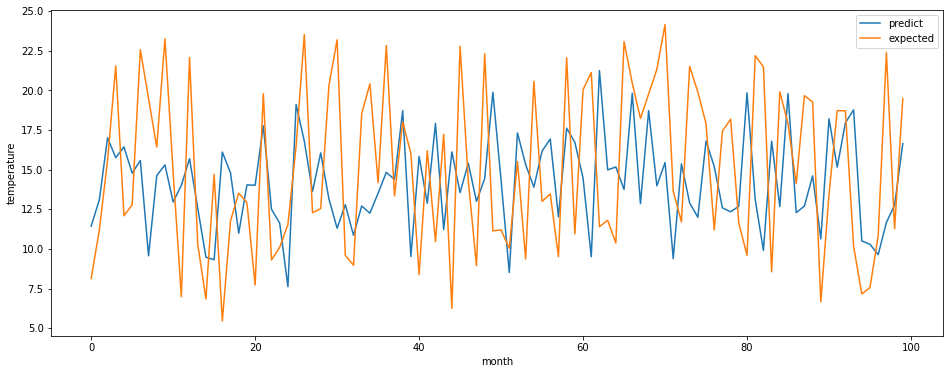

In [225]:

def inverse_scaling(y_inverted):
  y_inverted = np.c_[y_inverted, np.zeros(y_inverted.shape)]
  return min_max_scaler.inverse_transform(y_inverted)[:, 0]

print(model.evaluate(X_test, y_test))
y_predict = model.predict(X_test, verbose = 1)
y_predict_inverted = inverse_scaling(y_predict)[len(y_predict) - 100:]
y_test_inverted = inverse_scaling(y_test)[len(y_predict) - 100:]

plt.figure(1, figsize =(16, 6))
pred_plot,  = plt.plot(range(0, len(y_predict_inverted)), y_predict_inverted, label = 'predict')
expec_plot,  = plt.plot(range(0, len(y_test_inverted)), y_test_inverted, label = 'expected')
plt.legend(handles=[pred_plot, expec_plot])
plt.xlabel('month')
plt.ylabel('temperature')
plt.show()


Predict Future

In [261]:

X_future = []
for i in range(X.shape[0], X.shape[0] + 1):
  X_future.append(X[i - time_steps: i, :])

X_future = np.array(X_future)
y_future = model.predict(X_future)
y_future_inversed = inverse_scaling(y_future)
print('Next month temperature: ', y_future_inversed)

Next month temperature:  [11.24815058]
